In [3]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam#
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"C:/Users/xps/Desktop/mask project/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\Users\xps\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [8]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


58900480/58889256 [==============================] - 95s 2us/step


In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [12]:
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])

[INFO] compiling model...


C:\Users\xps\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
        aug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
            epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
95/95 [==============================] - 574s 6s/step - loss: 0.9108 - accuracy: 0.7610 - val_loss: 0.1539 - val_accuracy: 0.9596
Epoch 2/20
95/95 [==============================] - 554s 6s/step - loss: 0.3584 - accuracy: 0.9140 - val_loss: 0.0830 - val_accuracy: 0.9817
Epoch 3/20
95/95 [==============================] - 559s 6s/step - loss: 0.2216 - accuracy: 0.9433 - val_loss: 0.0556 - val_accuracy: 0.9870
Epoch 4/20
95/95 [==============================] - 538s 6s/step - loss: 0.1634 - accuracy: 0.9624 - val_loss: 0.0410 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 564s 6s/step - loss: 0.1475 - accuracy: 0.9628 - val_loss: 0.0344 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 527s 6s/step - loss: 0.1090 - accuracy: 0.9759 - val_loss: 0.0291 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 522s 5s/step - loss: 0.0883 - accuracy: 0.9759 - val_loss: 0.0257 - val_accura

In [20]:
predIdxs = model.predict(testX, batch_size=BS)

In [16]:
predIdxs = np.argmax(predIdxs, axis=1)


In [17]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       383
without_mask       1.00      0.99      1.00       384

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767



In [18]:
print("[INFO] saving mask detector model...")
model.save("vgg.model", save_format="h5")

[INFO] saving mask detector model...


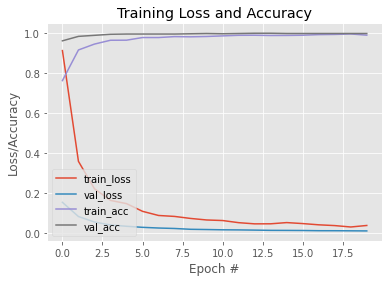

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [4]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
def prepare_image(file):
    img = image.load_img( file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array,axis=0)
    return preprocess_input(img_array_expanded_dims)
validpath=r'C:/Users/xps/Desktop/mask project/valid'
import cv2
import glob as gb
mobile=load_model("vgg.model")
class_labels=['Mask' ,'Without Mask']
files=gb.glob(pathname=str(validpath+'/*.jpg'))
for file in files :
    preprocessed_image = prepare_image(file)
    predictions = mobile.predict(preprocessed_image)
    for pred in predictions:
        (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    print('status:',label)
    

status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%
status: No Mask: 100.00%

In [7]:
from flask import Flask,render_template,Response,request
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import cv2
import numpy as np
%tb
import imutils
app = Flask(__name__)
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	#print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
prototxtPath = r"C:/Users/xps/Desktop/mask project/face_detector/deploy.prototxt"
weightsPath = r"C:/Users/xps/Desktop/mask project/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
path="C:/Users/xps/Desktop/mask project/vgg.model"
# load the face mask detector model from disk
maskNet = load_model("vgg.model")
def mask():
    print("[INFO] starting video stream...")
    #vs = VideoStream(src=0).start()
    camera=cv2.VideoCapture(0)
    # loop over the frames from the video stream
    while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
   
        success,frame = camera.read()
        if not success:
            break
        else:
            frame = imutils.resize(frame, width=800)

            # detect faces in the frame and determine if they are wearing a
            # face mask or not
            (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

            # loop over the detected face locations and their corresponding
            # locations
            for (box, pred) in zip(locs, preds):
                # unpack the bounding box and predictions
                (startX, startY, endX, endY) = box
                (mask, withoutMask) = pred

                # determine the class label and color we'll use to draw
                # the bounding box and text
                label = "Mask" if mask > withoutMask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
                if label== "No Mask":
                    print("dangerous")
                    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                # include the probability in the label
                label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

                # display the label and bounding box rectangle on the output
                # frame
                cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                    b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')

@app.route('/', methods=['POST', "get"])
def reaction():
        return render_template('react.html')
@app.route('/react_vedio', methods=['POST', "get"])
def react_vedio():
        return Response(mask(),
                    mimetype="multipart/x-mixed-replace; boundary=frame")  
if __name__ == '__main__':
    app.run()


dangerous


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 61)

In [16]:
print("finish")

finish
